In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request


%matplotlib inline

##  Reading input data

In [4]:
def create_matrix(n, qap_instance_file):
    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    return A


def get_nug(size):
    QAP_INSTANCE_URL = f'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{size}.dat'
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = create_matrix(n, qap_instance_file)
    B = create_matrix(n, qap_instance_file)
    
    return A, B, n

In [12]:
A, B, n = get_nug(12)
print(n)
print('Flow matrix:\n', A)
print('Distance matrix:\n', B)

12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  5.  2.  0.  0.

## Objective Function

In [14]:
def qap_objective_function(A, B, n, p):
    s = 0.0
    print('perm', p)
    for i in range(n):
        print(B[p[i], p])
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [15]:
qap_objective_function(A, B, n, np.random.permutation(n))

perm [ 7  9  0  3  1  8  2  5  4 10  6 11]
[ 0.  0.  6. 10.  0.  0.  5.  1.  0.  5. 10.  0.]
[0. 0. 1. 0. 5. 0. 2. 5. 5. 5. 2. 0.]
[6. 1. 0. 4. 5. 2. 2. 0. 1. 1. 0. 1.]
[10.  0.  4.  0.  0.  0.  0.  2.  5.  5.  2.  5.]
[0. 5. 5. 0. 0. 4. 3. 2. 2. 0. 2. 0.]
[ 0.  0.  2.  0.  4.  0.  5.  1.  0. 10.  5. 10.]
[5. 2. 2. 0. 3. 5. 0. 0. 0. 2. 0. 2.]
[ 1.  5.  0.  2.  2.  1.  0.  0. 10.  4.  5.  0.]
[ 0.  5.  1.  5.  2.  0.  0. 10.  0.  1.  0.  1.]
[ 5.  5.  1.  5.  0. 10.  2.  4.  1.  0.  3.  2.]
[10.  2.  0.  2.  2.  5.  0.  5.  0.  3.  0.  3.]
[ 0.  0.  1.  5.  0. 10.  2.  0.  1.  2.  3.  0.]


880.0

In [19]:
B[0, [0, 1, 2]]

array([0., 5., 2.])

 ## Simulated Annealing

In [2]:
def random_neighbor(n, p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q


def simulated_annealing(A, B, n, T, radius, alpha):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(A, B, n, p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(n, p, radius)
        q_cost = qap_objective_function(A, B, n, q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return costs


def solve_nug(size, T, radius, alpha):
    A, B, n = get_nug(size)
    
    t0 = time.time()
    costs = simulated_annealing(A, B, n, T, radius, alpha)
    elapsed_time = time.time() - t0
    
    return elapsed_time, costs

### NUG12 (OPT = 578)

In [35]:
size = 12
A, B, n = get_nug(size)
costs = simulated_annealing(A, B, n, T=500000, radius=1, alpha=1.0)
print(costs.min())

578.0


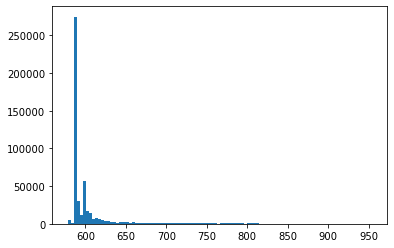

605.06742 43.493970875784605


In [36]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

### NUG14 (OPT = 1014)

In [43]:
time_elapsed, costs = solve_nug(14, 500000, 1, 1.0)
print(costs.min())

1014.0


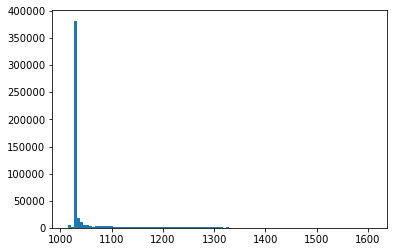

1047.668596 61.1901052408703


In [44]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

#### Iterations tinkering

In [45]:
for T in range(500000, 1000000+1, 250000):
    elapsed_time, costs = solve_nug(size=14, T=T, radius=1, alpha=1.0)
    print(f'iters: {T}, elapsed time: {elapsed_time}, min cost: {costs.min()}')

iters: 500000, elapsed time: 92.67399716377258, min cost: 1016.0
iters: 750000, elapsed time: 139.667076587677, min cost: 1014.0
iters: 1000000, elapsed time: 186.70514154434204, min cost: 1014.0


#### Radius tinkering

In [18]:
for radius in range(2, 20):
    elapsed_time, cost_min = solve_nug(14, 500000, radius, 1.0)
    print(f'radius: {radius}, elapsed time: {elapsed_time}, min cost: {cost_min}')

radius: 2, elapsed time: 115.4182641506195, min cost: 1034.0
radius: 3, elapsed time: 120.5247220993042, min cost: 1014.0
radius: 4, elapsed time: 142.1174943447113, min cost: 1016.0
radius: 5, elapsed time: 144.57813620567322, min cost: 1052.0
radius: 6, elapsed time: 158.25071811676025, min cost: 1026.0
radius: 7, elapsed time: 172.95860290527344, min cost: 1046.0


KeyboardInterrupt: 

### NUG15 (OPT = 1150)

In [46]:
elapsed_time, costs = solve_nug(size=15, T=1000000, radius=1, alpha=1.0)
print(f'iters: {T}, elapsed time: {elapsed_time}, min cost: {costs.min()}')

iters: 1000000, elapsed time: 197.47151708602905, min cost: 1150.0


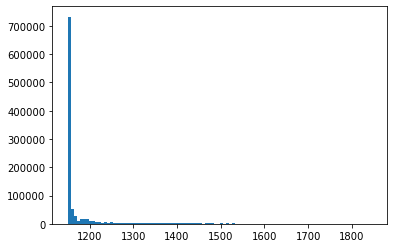

1177.983 73.93023012949452


In [47]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

### NUG16a (OPT = 1610)

In [49]:
elapsed_time, costs = solve_nug(size="16a", T=1000000, radius=1, alpha=1.0)
print(f'iters: {T}, elapsed time: {elapsed_time}, min cost: {costs.min()}')

iters: 1000000, elapsed time: 209.51820254325867, min cost: 1610.0


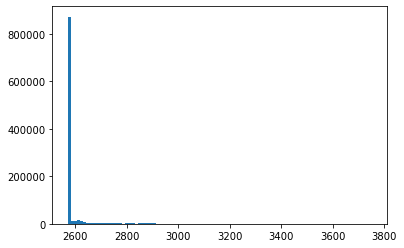

2596.468732 105.70714538909903


In [60]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

### NUG20 (OPT = 2570)

In [53]:
elapsed_time, costs = solve_nug(size=20, T=1000000, radius=1, alpha=1.5)
print(f'iters: {T}, elapsed time: {elapsed_time}, min cost: {costs.min()}')

iters: 1000000, elapsed time: 251.42137026786804, min cost: 2570.0


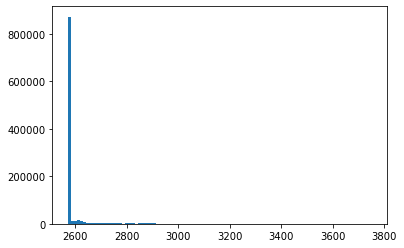

2596.468732 105.70714538909903


In [61]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

### NUG25 (OPT = 3744)

In [28]:
elapsed_time, cost_min = solve_nug(size=25, T=1000000, radius=1, alpha=1.5)
print(f'iters: {T}, elapsed time: {elapsed_time}, min cost: {cost_min}')

iters: 1000000, elapsed time: 320.51255345344543, min cost: 3744.0


## Successes and acceptable failures per iteration

In [63]:
def sa_with_rates(A, B, n, T, radius, alpha):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(A, B, n, p)
    costs = np.zeros(T)
    successes = np.zeros(T)
    acceptable_failures = np.zeros(T)
    for t in range(T):
        q = random_neighbor(n, p, radius)
        q_cost = qap_objective_function(A, B, n, q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            successes[t] = 1
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            acceptable_failures[t] = 1
        costs[t] = p_cost
    return costs, successes, acceptable_failures

In [108]:
def display_growth(growth):
    plt.figure()
    plt.plot(growth)
    plt.show()

    
def compute_growth(results):
    growth = np.zeros(len(results))
    growth[0] = results[0]
    for i in range(1, T):
        x = growth[i-1] + results[i]
        growth[i] += x
    return growth

### QAP 12

#### with alpha = 1.0

In [87]:
size = 12
T = 500000
A, B, n = get_nug(size)
_, successes, acceptable_failures = sa_with_rates(A, B, n, T=T, radius=1, alpha=1.0)

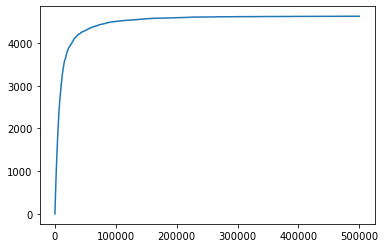

In [105]:
success_growth = compute_growth(successes)
display_growth(success_growth)

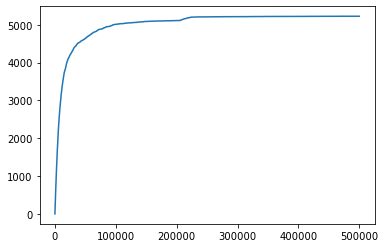

In [107]:
acceptable_failures_growth = compute_growth(acceptable_failures)
display_growth(acceptable_failures_growth)

#### with alpha = 0.1

In [109]:
size = 12
T = 500000
A, B, n = get_nug(size)
_, successes, acceptable_failures = sa_with_rates(A, B, n, T=T, radius=1, alpha=0.1)

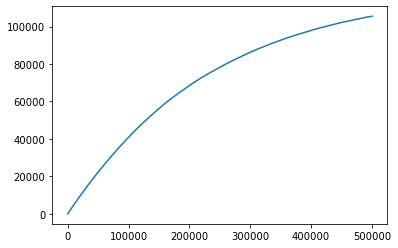

In [110]:
success_growth = compute_growth(successes)
display_growth(success_growth)

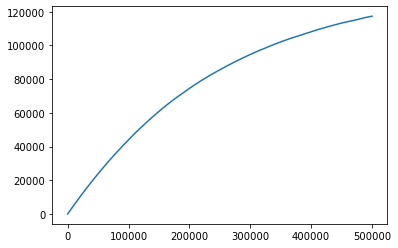

In [111]:
acceptable_failures_growth = compute_growth(acceptable_failures)
display_growth(acceptable_failures_growth)

### QAP 14

In [93]:
size = 14
T = 500000
A, B, n = get_nug(size)
_, successes, acceptable_failures = sa_with_rates(A, B, n, T=T, radius=1, alpha=1.0)

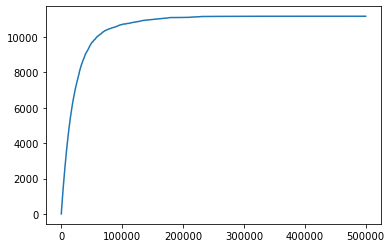

In [95]:
successes_growth = np.zeros(T)
successes_growth[0] = successes[0]
for i in range(1, T):
    x = successes_growth[i-1] + successes[i]
    successes_growth[i] += x

plt.figure()
plt.plot(successes_growth)
plt.show()

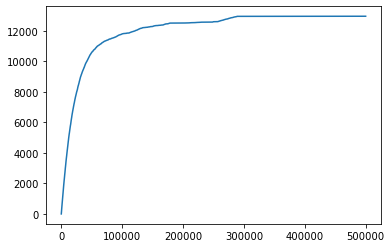

In [96]:
acceptable_failures_growth = np.zeros(T)
acceptable_failures_growth[0] = acceptable_failures[0]
for i in range(1, T):
    x = acceptable_failures_growth[i-1] + acceptable_failures[i]
    acceptable_failures_growth[i] += x

plt.figure()
plt.plot(acceptable_failures_growth)
plt.show()

### QAP25

In [97]:
size = 25
T = 500000
A, B, n = get_nug(size)
_, successes, acceptable_failures = sa_with_rates(A, B, n, T=T, radius=1, alpha=1.5)

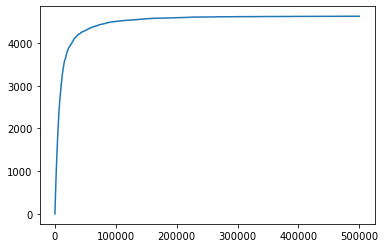

In [98]:
successes_growth = np.zeros(T)
successes_growth[0] = successes[0]
for i in range(1, T):
    x = successes_growth[i-1] + successes[i]
    successes_growth[i] += x

plt.figure()
plt.plot(successes_growth)
plt.show()

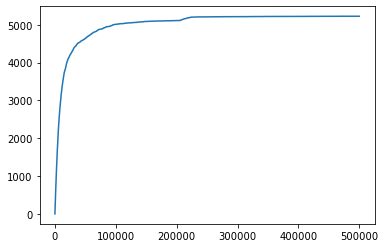

In [99]:
acceptable_failures_growth = np.zeros(T)
acceptable_failures_growth[0] = acceptable_failures[0]
for i in range(1, T):
    x = acceptable_failures_growth[i-1] + acceptable_failures[i]
    acceptable_failures_growth[i] += x

plt.figure()
plt.plot(acceptable_failures_growth)
plt.show()

## Differences between f(p) and f(q) on success

In [115]:
def hamming(perm1, perm2):
    difference = 0
    for x, y in zip(perm1, perm2):
        if x != y: difference +=1
    return difference

In [119]:
def sa_with_diffs(A, B, n, T, radius, alpha, cmpPerms):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(A, B, n, p)
    costs = np.zeros(T)
    permDiffs = []
    costDiffs = []
    for t in range(T):
        q = random_neighbor(n, p, radius)
        q_cost = qap_objective_function(A, B, n, q)
        if(q_cost < p_cost):
            permDiffs.append(cmpPerms(p, q))
            costDiffs.append(p_cost - q_cost)
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return costs, costDiffs, permDiffs

### QAP 12

In [135]:
size = 12
T = 500000
A, B, n = get_nug(size)
_, costDiffs, permDiffs = sa_with_diffs(A, B, n, T, 25, 1.0, hamming)

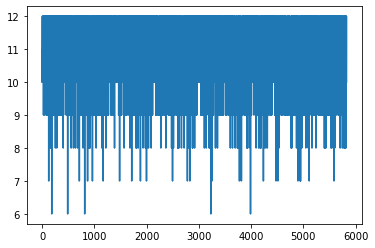

In [136]:
plt.figure()
plt.plot(permDiffs)
plt.show()

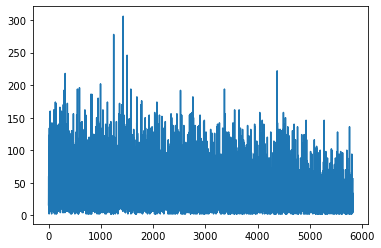

In [137]:
plt.figure()
plt.plot(costDiffs)
plt.show()

In [139]:
N = len(permDiffs)
tmp = np.zeros(N)
for i in range(N):
    tmp[i] = costDiffs[i] / permDiffs[i]

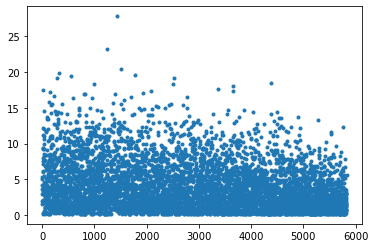

In [141]:
plt.figure()
plt.plot(tmp, '.')
plt.show()

In [9]:
time_elapsed, costs = solve_nug(12, 50000, 1, 1.0)
print(costs.min())

586.0


In [ ]:
time_elapsed, costs = solve_nug(12, 50000, 1, 1.0)
print(costs.min())